In [ ]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
data = pd.read_csv('Washington_State_HDMA-2016.csv') # description: https://cfpb.github.io/hmda-platform/#data-browser-api

/shared-libs/python3.9/py-core/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3139: DtypeWarning: Columns (23,24,25,28,29,30,38,39,40) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Data preparation

In [ ]:
# remove the unhelpful rows
# - Application withdrawn by applicant
# - Application approved but not accepted
# - Preapproval request denied by financial institution
# - Preapproval request approved but not accepted

data_clean = data.drop(data[(data.action_taken_name == "Application withdrawn by applicant") | \
                            (data.action_taken_name == "Application approved but not accepted") | \
                            (data.action_taken_name == "Preapproval request denied by financial institution") | \
                            (data.action_taken_name == "Preapproval request approved but not accepted")].index)

# turn our target into binary
data_clean['loan_approved'] = data_clean['action_taken_name'] == "Loan originated"

# remove unnecessary columns
data_clean = data_clean.drop(columns=["action_taken_name", \
                         "sequence_number", \
                         "respondent_id", \
                         "purchaser_type_name", \
                         "denial_reason_name_1", \
                         "denial_reason_name_2", \
                         "denial_reason_name_3"])

# replace nan with 0 in rate_spread
data_clean.fillna(0, inplace=True)


# turn categorial into dummies
categorial_names = list(set(data_clean.columns) - set(data_clean._get_numeric_data().columns))
data_clean = pd.get_dummies(data=data_clean, columns=categorial_names)

data_clean

,tract_to_msamd_income,rate_spread,population,minority_population,number_of_owner_occupied_units,number_of_1_to_4_family_units,loan_amount_000s,hud_median_family_income,applicant_income_000s,census_tract_number,...,applicant_race_name_2_White,co_applicant_race_name_4_Native Hawaiian or Other Pacific Islander,co_applicant_race_name_4_White,applicant_race_name_3_American Indian or Alaska Native,applicant_race_name_3_Asian,applicant_race_name_3_Black or African American,applicant_race_name_3_Native Hawaiian or Other Pacific Islander,applicant_race_name_3_White,owner_occupancy_name_Not owner-occupied as a principal dwelling,owner_occupancy_name_Owner-occupied as a principal dwelling
0,121.690002,0.0,8381.0,23.790001,2175.0,2660.0,227,73300.0,116.0,413.27,...,0,0,0,0,0,0,0,0,0,1
1,83.370003,0.0,4915.0,23.990000,1268.0,1777.0,240,57900.0,42.0,9208.01,...,0,0,0,0,0,0,0,0,0,1
2,91.129997,0.0,5075.0,11.820000,1136.0,1838.0,241,73300.0,117.0,414.00,...,0,0,0,0,0,0,0,0,0,1
3,146.169998,0.0,5032.0,8.590000,1525.0,1820.0,351,73300.0,315.0,405.10,...,0,0,0,0,0,0,0,0,0,1
4,162.470001,0.0,5183.0,10.500000,1705.0,2104.0,417,78100.0,114.0,907.00,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466553,91.070000,0.0,6792.0,16.889999,1763.0,2280.0,225,69900.0,54.0,103.01,...,0,0,0,0,0,0,0,0,0,1
466554,128.800003,0.0,4966.0,11.500000,1561.0,1870.0,100,69900.0,21.0,8.05,...,0,0,0,0,0,0,0,0,0,1
466555,99.669998,0.0,4950.0,29.639999,1594.0,1742.0,196,90300.0,0.0,219.05,...,0,0,0,0,0,0,0,0,0,1
466556,88.889999,0.0,3233.0,16.610001,1055.0,1278.0,169,73600.0,0.0,125.10,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
cols = ["loan_amount_000s", "applicant_income_000s", "rate_spread", "applicant_race_name_1_White", "application_date_indicator"]

X = data_clean[cols].values
y = data_clean['loan_approved'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train).type(torch.FloatTensor).reshape(-1, 1)

X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test).type(torch.FloatTensor).reshape(-1, 1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train, X_test = torch.Tensor(X_train), torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train), torch.Tensor(y_test)

In [ ]:
class LogisticRegression(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
     def forward(self, x):
         outputs = torch.sigmoid(self.linear(x))
         return outputs

In [ ]:
epochs = 1000
input_dim = X_train.shape[1]
output_dim = 1 
learning_rate = 0.03

model = LogisticRegression(input_dim, output_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

loss_list = []
# train
for epoch in tqdm(range(epochs), desc = 'Training Epochs'):
    y_model = model(X_train)
    # loss
    loss = criterion(y_model, y_train)
    loss_list.append(loss.item())
    loss.backward()
    # gradient descent
    optimizer.step()
    optimizer.zero_grad()

Training Epochs: 100%|██████████| 1000/1000 [00:16<00:00, 61.09it/s]


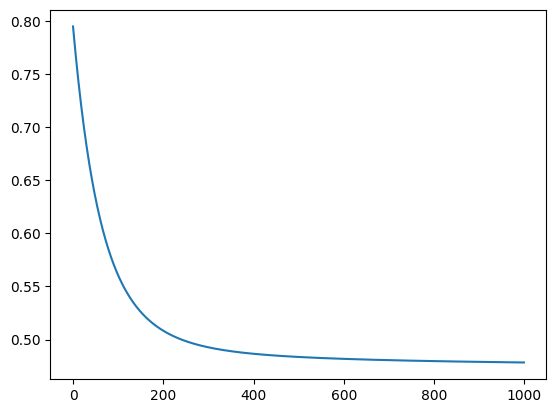

In [ ]:
plt.plot(loss_list)

In [ ]:
with torch.no_grad():
    y_model = model(X_test).round()
    acc = y_model.eq(y_test).sum() / y_test.shape[0]
    print(acc)

tensor(0.7914)


In [ ]:
pd.Series(y_model[:,0].detach().numpy()).value_counts()

1.0    103757
0.0     14570
dtype: int64

In [ ]:
pd.Series(y).value_counts()

True     263712
False    130709
dtype: int64

In [ ]:
for i in model.parameters():
    print(i)

Parameter containing:
tensor([[ 0.1068,  0.2412,  0.3473,  0.1396, -1.4241]], requires_grad=True)
Parameter containing:
tensor([0.6324], requires_grad=True)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=03c1f381-4bef-44c8-9167-00386ebceba9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>